# BPNet Hits Peak Set x Motif

Motifs scores for each peak set based on BPNet hits. 

Inputs:
1. BPNet motif hits
2. Peak sets
3. Motif group metadata (e.g. Vierstra motif clusters)

In [234]:
library(rtracklayer)
library(matrixStats)
library(reshape2)
library(ggplot2)
library(scales)
library(patchwork)

## Load Data

### BPNet Motif Hits

In [4]:
bpnet_motif_hits = import("../../analysis/20200723_motif_annotation/bpnet_scores/20201020_n62402/hits.bpnet.no_iPSC.all_peaks.FDR_0.1.bed")
bpnet_motif_hits

GRanges object with 5839504 ranges and 2 metadata columns:
            seqnames            ranges strand |                  name
               <Rle>         <IRanges>  <Rle> |           <character>
        [1]     chr1       42261-42271      - |        CEBPA_MA0102.3
        [2]     chr1       42261-42271      + | CEBPB_MOUSE.H11MO.0.A
        [3]     chr1       42276-42289      + |          JUN_MA0489.1
        [4]     chr1       42278-42288      + |     BATF+JUN_MA0462.1
        [5]     chr1       42280-42290      + |  JUND_HUMAN.H11MO.0.A
        ...      ...               ...    ... .                   ...
  [5839500]     chrY 26315267-26315285      - |         CTCF_MA0139.1
  [5839501]     chrY 26315267-26315283      - | CTCFL_HUMAN.H11MO.0.A
  [5839502]     chrY 26315268-26315279      - |  TYY1_HUMAN.H11MO.0.A
  [5839503]     chrY 26315268-26315279      - |  TYY1_MOUSE.H11MO.0.A
  [5839504]     chrY 26315268-26315279      - |          YY1_MA0095.2
                    score
     

### Peak Sets

In [7]:
peak_sets = list()
NUM_PEAK_SETS = 20
PEAK_SET_PATH = "../../analysis/20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/"

for (i in seq(NUM_PEAK_SETS)) {
    peak_sets[[i]] = import(sprintf("%s/idx%d.bed", PEAK_SET_PATH, i))
}

In [12]:
unlist(lapply(peak_sets, length))

[1] 24240 26454 19808 21589 15522 18279 16048 22858 16378 25712 18784 13720
[13] 14590 21201 19328 24442 19693 24842 14242 15708

### Motif Group Metadata

In [5]:
motifs = read.table("/srv/www/kundaje/surag/resources/motif_archetypes/motifs.tsv", 
                    header=T,
                   stringsAsFactors=F)
rownames(motifs) = motifs$Motif
motifs$Motif = NULL
dim(motifs)
head(motifs)

[1] 2174    8

,Cluster_ID,Database,Consensus,Relative_orientation,Width,Left_offset,Right_offset,Gene
,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
LHX6_homeodomain_3,1,Taipale_Cell_2013,TGATTGCAATCA,+,12,0,0,LHX6
Lhx8.mouse_homeodomain_3,1,Taipale_Cell_2013,TGATTGCAATTA,-,12,0,0,Lhx8
LHX2_MOUSE.H11MO.0.A,2,HOCOMOCO_v11,ACTAATTAAC,-,10,7,9,LHX2
LHX2_HUMAN.H11MO.0.A,2,HOCOMOCO_v11,AACTAATTAAAA,-,12,6,8,LHX2
LHX3_MOUSE.H11MO.0.C,2,HOCOMOCO_v11,TTAATTAGC,-,9,8,9,LHX3
NOBOX_HUMAN.H11MO.0.C,2,HOCOMOCO_v11,ACCAATTAG,-,9,7,10,NOBOX


In [6]:
motif_archetypes = read.table("/srv/www/kundaje/surag/resources/motif_archetypes/archetypes.tsv", 
                              header=T,
                             stringsAsFactors=F)
motif_archetypes = motif_archetypes[order(motif_archetypes$Cluster_ID), ]
rownames(motif_archetypes) = motif_archetypes$Cluster_ID
dim(motif_archetypes)
head(motif_archetypes)

[1] 286   8

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
2,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
3,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
4,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
5,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
6,6,HD/6,homeodomain,BARHL2_MA0635.1,18,1,16,11


## Process

### Make Counts Matrix

In [148]:
peak_x_motif_counts = matrix(0, nrow=NUM_PEAK_SETS, 
                                 ncol=length(unique(bpnet_motif_hits$name)))
rownames(peak_x_motif_counts) = seq(NUM_PEAK_SETS)
colnames(peak_x_motif_counts) = unique(bpnet_motif_hits$name)

In [149]:
NUM_PEAKS = list()

In [150]:
for (i in seq(NUM_PEAK_SETS)) {
    cur_peak_set = peak_sets[[i]]
    NUM_PEAKS[[i]] = length(cur_peak_set)
    
    # allows counting multiple hits per peak
    cur_motif_counts = table(bpnet_motif_hits[queryHits(findOverlaps(bpnet_motif_hits, cur_peak_set, type='within'))]$name)
    
    peak_x_motif_counts[i, names(cur_motif_counts)] = cur_motif_counts
}

In [151]:
head(peak_x_motif_counts)

,CEBPA_MA0102.3,CEBPB_MOUSE.H11MO.0.A,JUN_MA0489.1,BATF+JUN_MA0462.1,JUND_HUMAN.H11MO.0.A,JUN_HUMAN.H11MO.0.A,NANOG_MOUSE.H11MO.0.A,PO5F1_MOUSE.H11MO.0.A,AP2A_HUMAN.H11MO.0.A,AP2C_HUMAN.H11MO.0.A,⋯,Pou5f1+Sox2_MA0142.1,Foxc1.mouse_forkhead_2,TEAD3_TEA_1,TYY1_HUMAN.H11MO.0.A,TYY1_MOUSE.H11MO.0.A,YY1_MA0095.2,RFX2_HUMAN.H11MO.0.A,SIX1_HUMAN.H11MO.0.A,SIX2_MOUSE.H11MO.0.A,SIX2_HUMAN.H11MO.0.A
1,628,600,16136,10394,10353,10646,379,387,289,299,⋯,390,735,261,79,93,107,76,155,166,201
2,574,551,12472,7990,8145,8483,143,92,85,91,⋯,103,454,168,43,40,57,21,110,113,126
3,313,310,10717,6089,6965,7111,365,394,616,740,⋯,364,244,200,111,136,111,49,103,109,127
4,705,664,21904,13196,14165,14438,805,908,891,1066,⋯,864,732,414,194,209,190,140,258,276,314
5,385,420,15209,8548,9852,9928,1213,1319,1736,2129,⋯,1226,354,372,367,405,281,108,190,227,240
6,136,132,5419,3329,3502,3566,522,607,339,362,⋯,587,173,158,48,65,47,38,99,105,147


### Normalize Matrix

In [207]:
# filter
MIN_TOTAL_HITS = 2000
peak_x_motif_norm = peak_x_motif_counts[, colSums(peak_x_motif_counts)>MIN_TOTAL_HITS]

# row norm
peak_x_motif_norm = peak_x_motif_norm/rowSums(peak_x_motif_norm)

# col norm by total number of peaks in peakset
# may show higher counts for peak sets part of multiple cell states 
# which would as a result have more called motifs
# peak_x_motif_norm = t(t(peak_x_motif_norm)/unlist(NUM_PEAKS[rownames(peak_x_motif_counts)]))

# column norm to 0-1
peak_x_motif_norm = t(t(peak_x_motif_norm) - colMins(peak_x_motif_norm))
peak_x_motif_norm = t(t(peak_x_motif_norm)/colMaxs(peak_x_motif_norm))

head(peak_x_motif_norm)

,CEBPA_MA0102.3,CEBPB_MOUSE.H11MO.0.A,JUN_MA0489.1,BATF+JUN_MA0462.1,JUND_HUMAN.H11MO.0.A,JUN_HUMAN.H11MO.0.A,NANOG_MOUSE.H11MO.0.A,PO5F1_MOUSE.H11MO.0.A,AP2A_HUMAN.H11MO.0.A,AP2C_HUMAN.H11MO.0.A,⋯,Sox3_MA0514.1,PO5F1_HUMAN.H11MO.0.A,Pou5f1+Sox2_MA0142.1,Foxc1.mouse_forkhead_2,TEAD3_TEA_1,TYY1_HUMAN.H11MO.0.A,TYY1_MOUSE.H11MO.0.A,YY1_MA0095.2,SIX2_MOUSE.H11MO.0.A,SIX2_HUMAN.H11MO.0.A
1,0.7279151,0.7174862,0.8646978,0.8697038,0.8476569,0.8364684,0.024191500,0.0197795299,0.04021331,0.03617089,⋯,0.04851273,0.023756989,0.024487228,1.0000000,0.8132504,0.04299219,0.09335696,0.14113502,0.7637613,0.6505408
2,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.009391964,0.0009966257,0.00000000,0.00000000,⋯,0.02712215,0.003171229,0.003505008,0.9189530,0.7742520,0.00000000,0.00000000,0.06366852,0.7765733,0.5986644
3,0.3464335,0.3422208,0.5581863,0.4918446,0.5514313,0.5399423,0.022638377,0.0200275721,0.11974133,0.13220261,⋯,0.10834833,0.021601510,0.021878677,0.3216020,0.5867316,0.13191697,0.20985802,0.15149463,0.4366081,0.3587677
4,0.4507547,0.4278382,0.6536109,0.6130474,0.6438241,0.6293684,0.030815196,0.0291200204,0.09288619,0.10283080,⋯,0.12044134,0.033057190,0.033048259,0.5560838,0.7128675,0.12987491,0.16230834,0.14111604,0.7041288,0.5567237
5,0.1728722,0.1799717,0.3315051,0.2874776,0.3226754,0.3111683,0.036860694,0.0332801358,0.15332200,0.17239062,⋯,0.16099474,0.037205240,0.036612315,0.1983552,0.4487640,0.26898681,0.31953677,0.18921433,0.3776935,0.2707039
6,0.2974992,0.2836314,0.5644703,0.5403133,0.5543738,0.5412918,0.082528659,0.0810008792,0.13484358,0.12859688,⋯,0.12649271,0.091101333,0.092966884,0.4602665,1.0000000,0.08906444,0.19303745,0.09231227,1.0000000,1.0000000


In [208]:
dim(peak_x_motif_norm)

[1]  20 120

In [209]:
all(colMins(peak_x_motif_norm)==0)
all(colMaxs(peak_x_motif_norm)==1)

[1] TRUE

[1] TRUE

In [210]:
all(colnames(peak_x_motif_norm) %in% rownames(motifs))

[1] TRUE

In [211]:
to_plot_df = melt(peak_x_motif_norm)

to_plot_df$peak_set_idx = factor(to_plot_df$Var1, levels=rev(sort(unique(to_plot_df$Var1))))
to_plot_df$score = to_plot_df$value
to_plot_df$TF = as.character(to_plot_df$Var2)

df_tf_fam = factor(motif_archetypes[motifs[to_plot_df$TF, "Cluster_ID"], "Name"])
to_plot_df$TF_family = as.character(df_tf_fam)

In [212]:
# total counts of motifs
tot_motif_count = colSums(peak_x_motif_counts)

In [213]:
dim(to_plot_df)

[1] 2400    7

### Remove Correlated TFs

In [214]:
# remove highly correlated TFs per family
# https://stackoverflow.com/questions/18275639/remove-highly-correlated-variables

REMOVE_ABOVE = 0.9

keep_TFs = c()
for (x in unique(to_plot_df$TF_family)) {
    cur_tf_df = to_plot_df[to_plot_df$TF_family==x, c("score", "TF", "peak_set_idx")]
    if (length(unique(cur_tf_df$TF))==1) {
        keep_TFs = c(keep_TFs, unique(cur_tf_df$TF))
        next 
    }
    
    # make TF x sample matrix 
    tf_sample_matrix = matrix(0, nrow=length(unique(cur_tf_df$TF)), ncol=length(unique(cur_tf_df$peak_set_idx)))
    rownames(tf_sample_matrix) = unique(cur_tf_df$TF)
    colnames(tf_sample_matrix) = unique(cur_tf_df$sample)
    
    for (i in seq(1, dim(cur_tf_df)[1])) {
        tf_sample_matrix[cur_tf_df[i, "TF"], cur_tf_df[i, "peak_set_idx"]] = cur_tf_df[i, "score"]
    }
    
    # reorder TFs to bring those with most raw count up
    tf_sample_matrix = tf_sample_matrix[rev(order(tot_motif_count[rownames(tf_sample_matrix)])), ]
    
    # remove those with high correlation to another
    tf_cor = cor(t(tf_sample_matrix), method='spearman')
    tf_cor[upper.tri(tf_cor)] <- 0
    diag(tf_cor) <- 0
    keep_TFs = c(keep_TFs, 
                 rownames(tf_cor)[!apply(tf_cor,1,function(x) any(x > REMOVE_ABOVE))])

}

length(keep_TFs)

[1] 44

In [215]:
to_plot_df = to_plot_df[to_plot_df$TF %in% keep_TFs, ]
dim(to_plot_df)
length(unique(to_plot_df$TF))

[1] 880   7

[1] 44

In [216]:
TF_family_order = c('POU/1', 
                    'OCT4+SOX2', 
                    'SOX/1', 
                    'KLF/SP/1',
                    'KLF/SP/2', 
                    'AP1/1',
                    'CCAAT/CEBP',                    
                    'CREB/ATF/1',
                    'CTCF', 
                    'TFAP2/1', 
                    'TEAD',
                    'RUNX/1',
                    'ETS/1',
                    'ETS/2')
TF_family_order = c(TF_family_order, as.character(unique(to_plot_df$TF_family))[!as.character(unique(to_plot_df$TF_family)) %in% TF_family_order])

to_plot_df$TF_family = factor(to_plot_df$TF_family,
                                  level=TF_family_order)

In [217]:
# remove SeqBias and Unknown and GFY/GFX
# to_plot_df = to_plot_df[!grepl("(SeqBias|Unknown|GFY|GFX)", to_plot_df$TF) ,]
# length(unique(to_plot_df$TF))

In [218]:
quantile(to_plot_df$value, c(0, 0.1, 0.5, 0.9, 0.99, 1))

0%        10%        50%        90%        99%       100% 
0.00000000 0.04554124 0.32670042 0.85440617 1.00000000 1.00000000

### Plot

In [219]:
# motify TF name
to_plot_df$TF = unlist(lapply(strsplit(to_plot_df$TF, "\\."), "[[", 1))

In [226]:
# https://dmitrijskass.netlify.app/2019/06/30/multi-level-labels-with-ggplot2/
# https://www.r-graph-gallery.com/320-the-basis-of-bubble-plot.html
p <- ggplot(to_plot_df, aes(x = TF, 
                            y = peak_set_idx, 
                            fill=score)) +
geom_tile() +
facet_grid(~factor(TF_family), #, levels=sample(unique(consolidated_df$TF_family))),
           scales = "free_x",
          space = "free_x") +
#           switch = "x") +
scale_fill_gradient(low="white",
                      high="red",
                      limits=c(0.05, 0.95),
                      oob=squish,
                      name="TF Score") +
ylab("") +
theme_classic() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95), # rotate TF text
     strip.text.x.top = element_text(angle = 90, hjust=0, vjust=0.5), # rotate TF family text
     panel.spacing = unit(0.2, "lines"), # space between TF families
     text = element_text(size=15), 
     strip.background = element_blank(),
     panel.background = element_rect(fill = NA, color = "black", size=1)) # box around TF families

In [230]:
pg <- ggplotGrob(p)

# avoid stripping of facet label
# https://stackoverflow.com/questions/49740215/ggplot-facet-grid-label-cut-off
for(i in which(grepl("strip-t", pg$layout$name))){
  pg$grobs[[i]]$layout$clip <- "off"
}

In [288]:
POINTS = c(1.9, 2.6, 4.5, 6.8, 8.4)
LABELS = c("Constant", "Close/\nOpen", "Transient", "Open/\nClose")
XOFF = 9
ARROWDTH = 1
XTXT = 5
GAP = 0.1
SZ = .75
TXTSZ = 5

left_annotate_plot = ggplot() + 
                theme_void() +
                geom_line() +
                coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
                               ylim=c(0.5,9.5)) # this let's use 0-10 on y axis to place items

for (i in seq(length(POINTS)-1)) {
    left_annotate_plot = left_annotate_plot + annotate("segment", 
                                                       x = XOFF, 
                                                       xend = XOFF, 
                                                       y = POINTS[i], 
                                                       yend=POINTS[i+1]-GAP, 
                                                       size=SZ, 
                                                       colour="black") +
                          annotate("segment",
                                  x = XOFF - (ARROWDTH/2),
                                  xend = XOFF + (ARROWDTH/2),
                                  y=POINTS[i],
                                  yend=POINTS[i],
                                  size=SZ) +
                          annotate("segment",
                                  x = XOFF - (ARROWDTH/2),
                                  xend = XOFF + (ARROWDTH/2),
                                  y=POINTS[i+1]-GAP,
                                  yend=POINTS[i+1]-GAP,
                                  size=SZ) +
    
                          annotate("text", 
                                   x=XTXT, 
                                   y=(POINTS[i]+POINTS[i+1]-GAP)/2, 
                                   angle=90, 
                                   size=TXTSZ,
                                   label=LABELS[i])
}

In [296]:
annotated <- wrap_plots(left_annotate_plot,
                        pg,
                        widths=c(1,14))

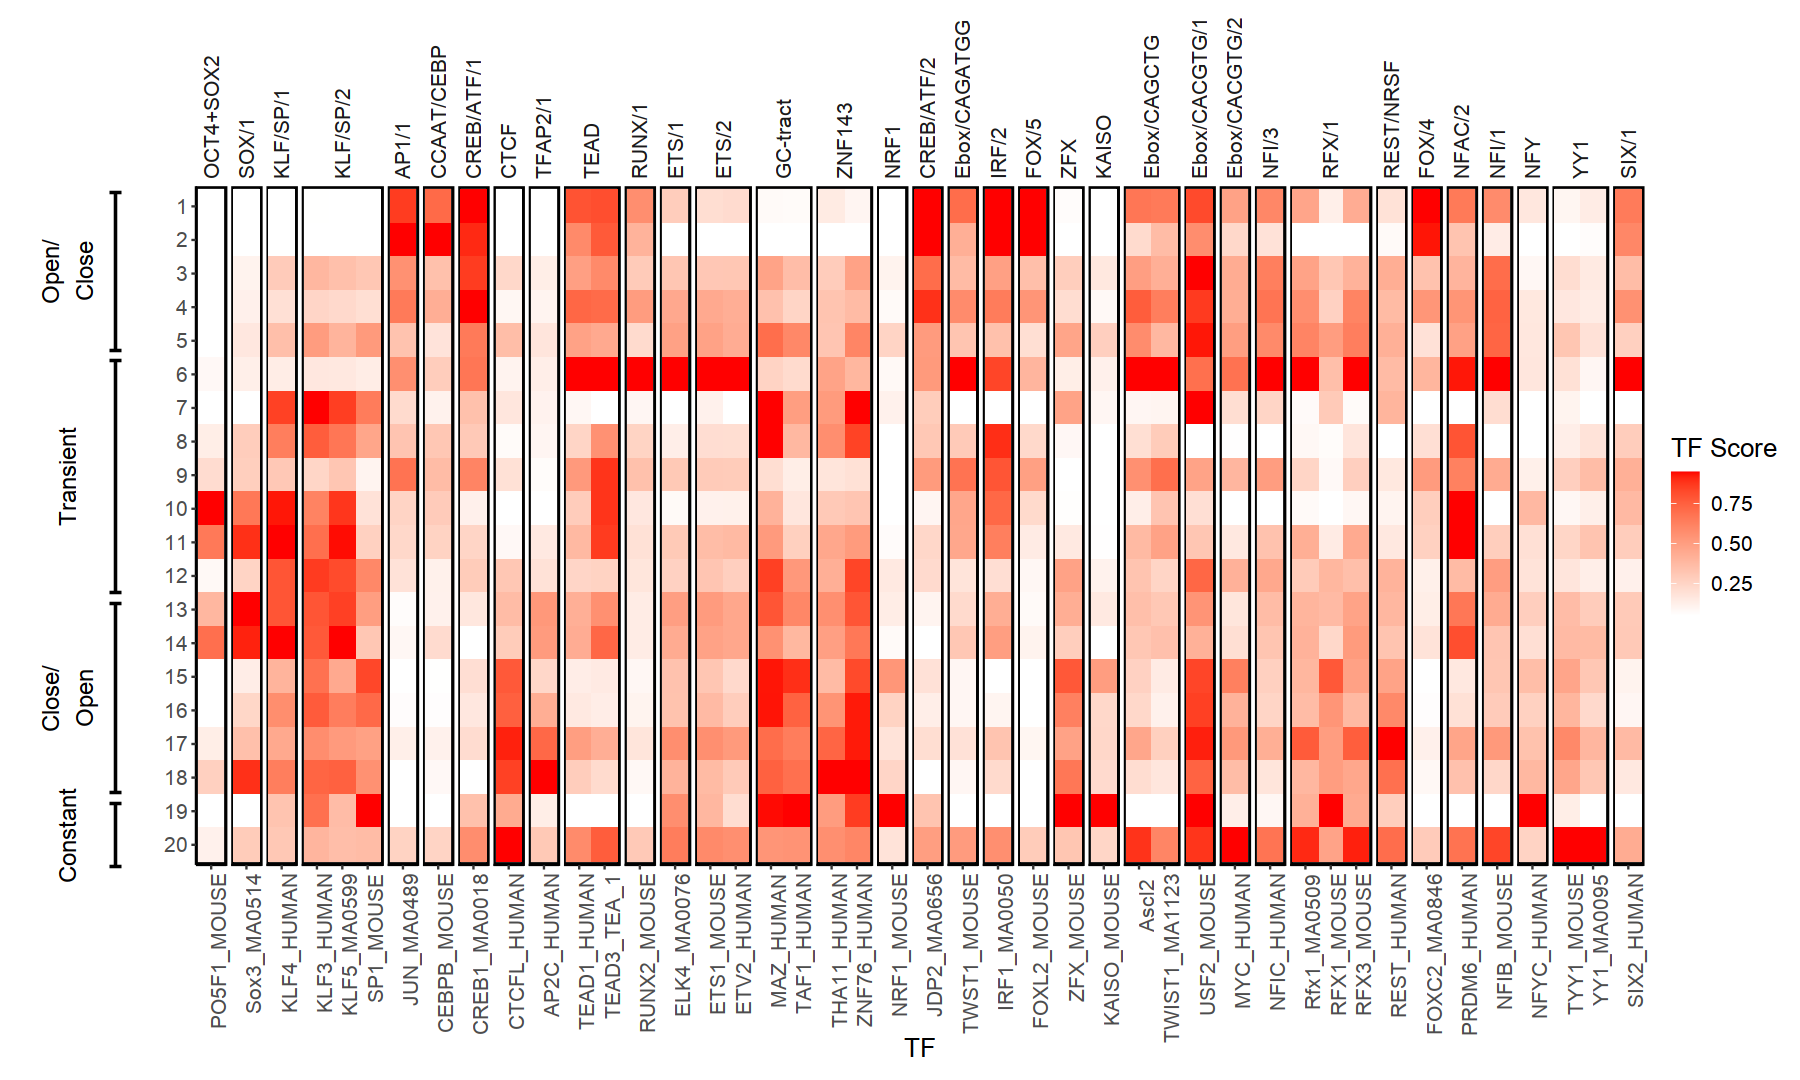

In [297]:
options(repr.plot.width = 15, repr.plot.height = 9)

annotated

In [299]:
saveRDS(annotated, file=sprintf("./subfigs/%s_peaksets.rds",
                                format(Sys.Date(), "%Y%m%d")))

### OSK Ratios

In [293]:
osk_counts = peak_x_motif_counts[,grepl("PO5F1_HUMAN|Sox3|KLF4", colnames(peak_x_motif_counts), ignore.case = F)]
rownames(osk_counts) = sub('idx', '', rownames(osk_counts))
head(osk_counts)

,KLF4_HUMAN.H11MO.0.A,Sox3_MA0514.1,PO5F1_HUMAN.H11MO.0.A
1,458,72,390
2,102,39,105
3,2132,112,369
4,2597,211,880
5,5768,338,1263
6,540,62,583


In [294]:
osk_frac_melted = melt(osk_counts/rowSums(osk_counts))
osk_frac_melted$Var1 = factor(osk_frac_melted$Var1, levels=sort(unique(osk_frac_melted$Var1)))

head(osk_frac_melted, 2)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,1,KLF4_HUMAN.H11MO.0.A,0.4978261
2,2,KLF4_HUMAN.H11MO.0.A,0.4146341


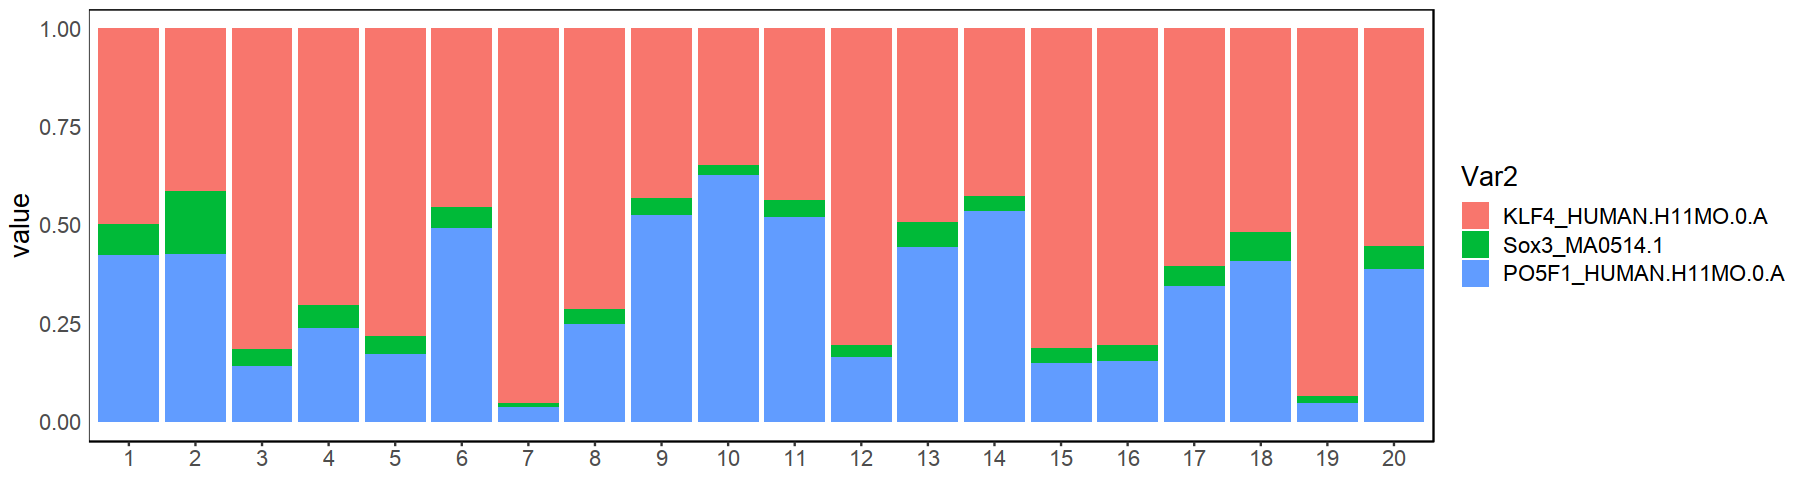

In [295]:
options(repr.plot.width = 15, repr.plot.height = 4)

ggplot(osk_frac_melted, aes(x=Var1, y=value, fill=Var2)) +
geom_bar(position='fill', stat='identity') +
theme_classic() +
theme(plot.title = element_text(hjust = 0.5),
    text = element_text(size=16),
    axis.line=element_blank(),
    axis.ticks.y=element_blank(),
    axis.title.x = element_blank(),
    panel.border = element_rect(colour = "black", fill=NA, size=0.5))

---

In [ ]:
sessionInfo()